In [1]:
pip install PyPortfolioOpt

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yfinance

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pulp

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install quandl

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.3.0/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
#equal risk contribution / risk parity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df= pd.read_csv("input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
rets=df.pct_change()
#rets = df[1:]
rets.head()

,DAI-USD,BUSD-USD,TUSD-USD,USDC-USD,USDT-USD
Date,,,,,
2019-11-22,NaN,NaN,NaN,NaN,NaN
2019-11-23,0.023861,0.009837,0.009095,0.010484,0.010054
2019-11-24,-0.013788,0.007578,0.006457,-0.002832,0.004332
2019-11-25,0.004740,-0.016237,-0.013968,-0.008411,-0.014157
2019-11-26,-0.000919,0.006695,0.005833,0.007539,0.006638


In [6]:
cov = rets.cov()

# Equal-weights function
def equal_weights(rets):
    n = len(rets.columns)
    weights = pd.Series(1/n, index = rets.columns)
    return weights

# Portfolio Volatility
def pf_vol(weights, cov):
    return (weights.T @ cov @ weights)**0.5

# Risk-contributions for each asset towards the overall portfolio volatility
def risk_cont(weights, cov):
    pf_volatility = pf_vol(weights, cov) ** 2
    risk = cov@weights
    risk_contribution = np.multiply(risk, weights.T)/pf_volatility
    return risk_contribution

<AxesSubplot:title={'center':'Risk allocation of an equally-weight dollar portfolio'}>

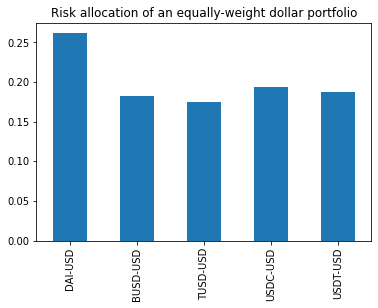

In [7]:
# Risk-contributions for an equally-weighted portfolio
risk_cont(equal_weights(rets), cov).plot.bar(title = "Risk allocation of an equally-weight dollar portfolio")

In [8]:
from scipy.optimize import minimize

# Find optimal dollar weights such that the risk-contributions meet a target contribution level, in this case being 1/n = 0.2 for each asset

def t_risk_cont(t_risk, cov):
    n = cov.shape[0]
    initial_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n
    weights_constraint = {'type': 'eq',
                         'fun': lambda weights: np.sum(weights) - 1}
    def msd(weights, t_risk, cov):
        contributions = risk_cont(weights, cov)
        return ((contributions - t_risk)**2).sum()
    
    weights = minimize(msd, initial_guess,
                       args=(t_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_constraint,),
                       bounds=bounds)
    return weights.x

def equal_risk_cont(cov):
    n = cov.shape[0]
    return t_risk_cont(np.repeat(1/n, n), cov)

<AxesSubplot:title={'center':'Risk Contributions of a Risk Parity portfolio'}>

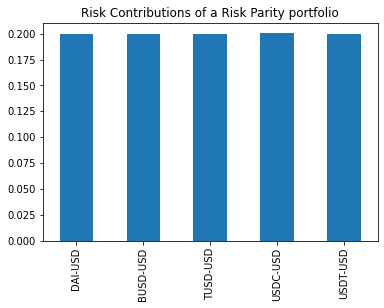

In [9]:
# Risk-parity allocation levels for risk. We see that they are equal i.e 0.2

risk_cont(equal_risk_cont(cov), cov).plot.bar(title="Risk Contributions of a Risk Parity portfolio")

In [10]:
# Find optimal weights to put in each industry based on the above risk-allocation levels above of 0.2

def sample_covariance(rets):
    return rets.cov()

def weight_rp(rets):
    est_cov = sample_covariance(rets)
    return equal_risk_cont(est_cov)

pd.DataFrame(weight_rp(rets) * 100, index = rets.columns, columns = ["Weight"])

,Weight
DAI-USD,17.199826
BUSD-USD,20.664406
TUSD-USD,21.716573
USDC-USD,20.057629
USDT-USD,20.361566
